<left>FINM 33160 - Machine Learning In Finance</left>
<left>Winter 2023</left>
<br>
<h1><center> Homework 4 </center></h1>
<center> Due - 23:59 [CST] March 5th, 2023</center>
<br>
<h3>Ki Hyun</h3>
<h3>Student ID: 12125881</h3>

#### Imports

In [1]:
%matplotlib inline

In [2]:
import warnings
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from collections import Counter
import pickle

import lightgbm
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation

import optuna
from optuna.trial import Trial
import optuna.integration.lightgbm as lgb

from functools import partial

In [3]:
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('use_inf_as_na', True)

In [5]:
scaler = StandardScaler()

#### Constants

In [6]:
HOME_dir = r'C:\Users\kwhyu\OneDrive - The University of Chicago\2023-1 Winter\FINM 33160\FINM-33160-W23'
RF_shap_features_dir = r'Lecture 8/Random Forest Parameters/shap_features.pkl'
RF_optimal_hyper_dir = r'Lecture 8/Random Forest Parameters/optimal_hyperparameters.pkl'
GB_shap_features_dir = r'Lecture 8/Gradient Boosting Parameters/shap_features_gb_clf_01.pkl'
GB_classifiers_dir = r'Lecture 8/Gradient Boosting Parameters/classifiers_gb_clf_01.pkl'
raw_data_dir = r'dataset.pkl'
SPY_dir = r'SPY_cum_ret.pkl'

#### Helper Functions

In [7]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
        return 0

In [8]:
def optimal_features(shap_features):
    total = []
    for i in range(len(shap_features)):
        for item in shap_features[i].values.tolist():
            total.append(item)
    features = list(set(total))

    appearance = []
    for feature in features:
        appearance.append(total.count(feature))

    return pd.DataFrame({'features': features, 'appearance': appearance}).sort_values(by = 'appearance',
                                                                                      ascending=False).head(10)

### Data

In [9]:
raw_data = pd.read_pickle(os.path.join(HOME_dir, raw_data_dir))
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [10]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [11]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

In [12]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [13]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [14]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [15]:
training_labels = [d['rel_performance'].values for d in training_frames]

## Problem 1.

### Random Forest

In [16]:
RF_classifiers = []

In [17]:
with open(os.path.join(HOME_dir, RF_optimal_hyper_dir),'rb') as f:
    optimal_hyperparameters = pickle.load(f)

In [18]:
for hyp_par in optimal_hyperparameters:
    rf_clf = RandomForestClassifier(**hyp_par)
    RF_classifiers.append(rf_clf)

In [19]:
with open(os.path.join(HOME_dir, GB_classifiers_dir),'rb') as f:
    GB_classifiers = pickle.load(f)

In [20]:
with open(os.path.join(HOME_dir, RF_shap_features_dir),'rb') as f:
    RF_features = pickle.load(f)

In [21]:
with open(os.path.join(HOME_dir, GB_shap_features_dir),'rb') as f:
    GB_features = pickle.load(f)

In [22]:
shap_features = optimal_features(RF_features)['features'].values.tolist()

In [23]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]

opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features].values),
                                  columns=shap_features) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features].values),
                              columns=shap_features) for i in range(len(start_dates)-1)]

In [24]:
classifiers = RF_classifiers
x_RF = [1]
ret_RF = []

for i in range(len(start_dates)-1):

        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_RF.append(profit_i)
        num_names = len(opt_test_data[i])
        x_RF.append(x_RF[i] + (x_RF[i]/num_names)*profit_i)

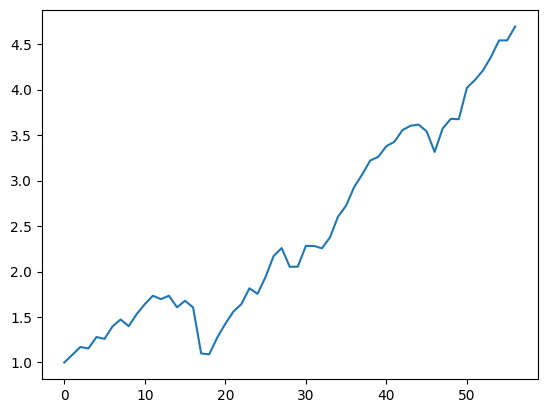

In [25]:
plt.plot(x_RF);

### Gradient Boosting

In [26]:
shap_features = optimal_features(GB_features)['features'].values.tolist()

In [27]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]

opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features].values),
                                  columns=shap_features) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features].values),
                              columns=shap_features) for i in range(len(start_dates)-1)]

In [28]:
classifiers = GB_classifiers
x_GB = [1]
ret_GB = []

for i in range(len(start_dates)-1):

        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_GB.append(profit_i)
        num_names = len(opt_test_data[i])
        x_GB.append(x_GB[i] + (x_GB[i]/num_names)*profit_i)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160

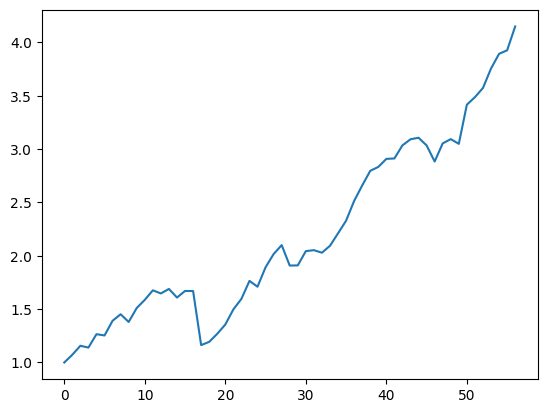

In [29]:
plt.plot(x_GB);

### Results

In [30]:
SPY = pd.read_pickle(os.path.join(HOME_dir, SPY_dir))

In [31]:
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['RF strategy'] = x_RF
SPY['GB strategy'] = x_GB

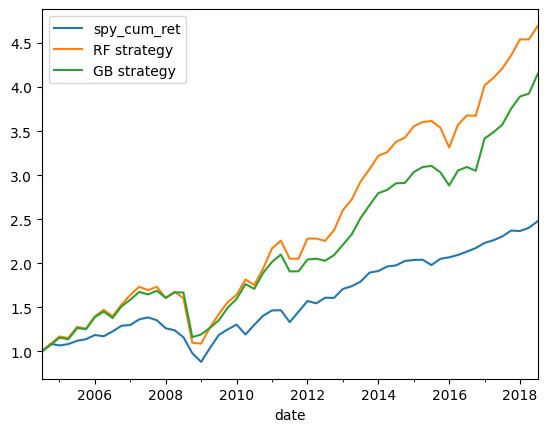

In [32]:
SPY.plot();

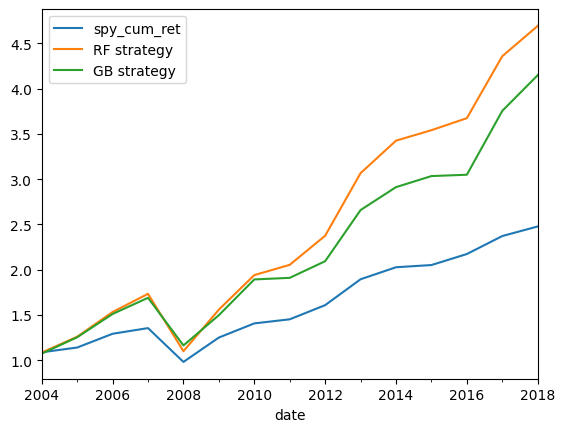

In [33]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [34]:
for strategy in ['RF strategy', 'GB strategy']:
    strategy_mean_ret = (SPY[strategy] - 1).diff().mean()
    strategy_std = (SPY[strategy] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    print(strategy, 'Sharpe Ratio:', strategy_sr)

RF strategy Sharpe Ratio: 0.8123660773772738
GB strategy Sharpe Ratio: 0.7603410521099914


## Problem 2.

In [35]:
def objective(trial:Trial, SPY = None, RF = None, GB = None,):
    w_1 = trial.suggest_float('RF strategy weight', 0, 1, step=0.001)
    w_2 = trial.suggest_float('GB strategy weight', 0, 1, step=0.001)
    w_3 = 1 - w_1 - w_2

    ret = w_1 * RF + w_2 * GB + w_3 * SPY

    strategy_mean_ret = (ret - 1).diff().mean()
    strategy_std = (ret - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std

    return strategy_sr

In [36]:
SPY = pd.read_pickle(os.path.join(HOME_dir, SPY_dir))

In [37]:
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['RF strategy'] = x_RF
SPY['GB strategy'] = x_GB

In [38]:
study = optuna.create_study(direction='maximize')

[I 2023-03-05 19:25:39,742] A new study created in memory with name: no-name-0a86ca83-164a-46ad-a137-5f481a49162a


In [39]:
%%time
study.optimize(partial(objective,
                           SPY = SPY['spy_cum_ret'],
                           RF = SPY['RF strategy'],
                           GB = SPY['GB strategy']),
                   n_trials = 200, n_jobs = -1)

[I 2023-03-05 19:25:39,758] Trial 0 finished with value: 0.48154487264694407 and parameters: {'RF strategy weight': 0.115, 'GB strategy weight': 0.758}. Best is trial 0 with value: 0.48154487264694407.
[I 2023-03-05 19:25:39,764] Trial 1 finished with value: 0.48978617975636835 and parameters: {'RF strategy weight': 0.34, 'GB strategy weight': 0.534}. Best is trial 1 with value: 0.48978617975636835.
[I 2023-03-05 19:25:39,768] Trial 2 finished with value: 0.5031034243479896 and parameters: {'RF strategy weight': 0.215, 'GB strategy weight': 0.45}. Best is trial 2 with value: 0.5031034243479896.
[I 2023-03-05 19:25:39,774] Trial 3 finished with value: 0.4918750492134905 and parameters: {'RF strategy weight': 0.136, 'GB strategy weight': 0.14200000000000002}. Best is trial 2 with value: 0.5031034243479896.
[I 2023-03-05 19:25:39,783] Trial 4 finished with value: 0.49504467371609767 and parameters: {'RF strategy weight': 0.669, 'GB strategy weight': 0.222}. Best is trial 2 with value: 0.5

CPU times: total: 6.19 s
Wall time: 5.73 s


In [40]:
study.best_params

{'RF strategy weight': 0.456, 'GB strategy weight': 0.065}

In [41]:
SPY['Mixture strategy'] = study.best_params.get('RF strategy weight') * SPY['RF strategy'] + \
                          study.best_params.get('GB strategy weight') * SPY['GB strategy'] + \
                          (1 - 0.363 - 0.147) * SPY['spy_cum_ret']

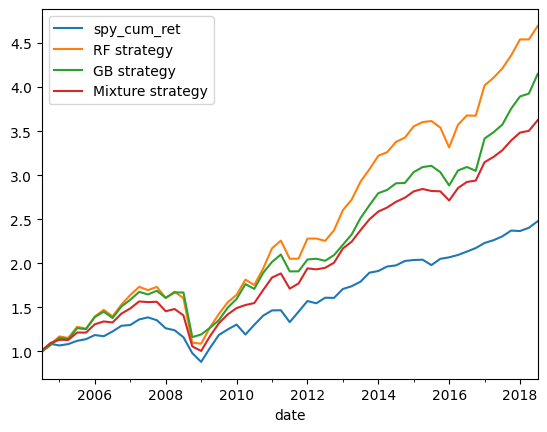

In [42]:
SPY.plot();

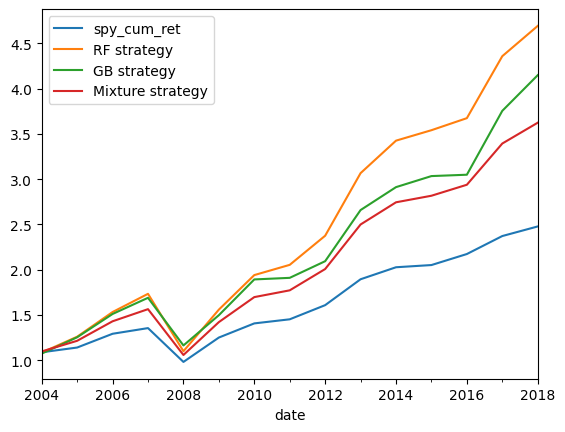

In [43]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [44]:
for strategy in ['RF strategy', 'GB strategy', 'Mixture strategy']:
    strategy_mean_ret = (SPY[strategy] - 1).diff().mean()
    strategy_std = (SPY[strategy] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    print(strategy, 'Sharpe Ratio:', strategy_sr)

RF strategy Sharpe Ratio: 0.8123660773772738
GB strategy Sharpe Ratio: 0.7603410521099914
Mixture strategy Sharpe Ratio: 0.7613315619704577
